# Класификационни и регресионни дървета

Целите днес: 
- Предварителна обработка (preprocessing) на категорийни променливи - `LabelEncoder` и `OneHotEncoder`
- Класификационните дървета (decision trees)
- Random forest 
- Информационна печалба (information gain), ентропия, Gini, мискласификация
- Регуларизация при дърветата 

Преди това: да си припомним малко от предния път.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display


%matplotlib inline

# NumPy и векторизация

Повечето операции в NumPy работят с така наречената векторизация. Това по-лесно се илюстрира с пример:

In [71]:
np.array([1, 2, 3, 4]) * 5

array([ 5, 10, 15, 20])

In [72]:
np.array([1, 2, 3]) * np.array([3, 4, 5])

array([ 3,  8, 15])

In [73]:
np.array([8, 3, 4, 1, 9, 4]) > 4

array([ True, False, False, False,  True, False])

In [74]:
(np.array([8, 3, 4, 1, 9, 4]) > 4).astype(float)

array([1., 0., 0., 0., 1., 0.])

## Кодиране на категорийните данни с числа - LabelEncoder

Ако има категорийни данни (например низове), може да ползваме `LabelEncoder` да ги заменим с числа:

In [75]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(["red", "green", "red", "blue", "red", "green"])

colors = ["green", "green", "blue"]

print("transofrmed:", encoder.transform(["green", "green", "blue"])) 
print("inverse:    ", encoder.inverse_transform([0, 1, 2]))

transofrmed: [1 1 0]
inverse:     ['blue' 'green' 'red']


## OneHotEncoder

Може да кодираме категории с label encoder, когато в категориите има някакъв естествен ред (напр. 4 е по-голямо от 2). Ако няма такъв ред обаче, на най-добре е да ползваме one-hot – така създаваме по една характеристика за всяка категория, като тази характеристика има стойности 0 или 1.

In [76]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit([[0],
             [1], 
             [0], 
             [2]])

print(encoder.transform([[0], [1], [1], [2], [0]]).toarray())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [77]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit([[0], 
             [1], 
             [0], 
             [2]])

print(encoder.transform([[0], [1], [1], [2], [0]]).toarray())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


Но да се върнем към днешната тема!

# Класификационни дървета (decision trees)

Характеристики: 
- Лесен за разбиране и интерпретация 
- Подходящ за проблеми с повече от два класа 

Какво представлява: 
- Класификационното дърво представлява една информационна структура, състояща се от възли, съединени със дъги – клони. 
- Всеки възел определя някой тест – проверка на стойността на определена характеристика от примера, а всеки клон, излизащ от този възел, съответства на една от възможни стойности на проверяваната характеристика.
- Листата на класификационното дърво представляват стойностите на целевия атрибут. 

Алгоритъм за предсказване:
- Класифицирането на новия пример започва от най-горния възел на дървото (коренът) и се осъществява чрез проверка
за стойността на характеристиката, описана в този възел; 
- след това примерът се “пуска” надолу по клона, който съответства на конкретната стойност на проверявания атрибут в дадения пример. 
- Описаният процес се повтаря в текущия възел, докато примерът не стигне до някое от листата на дървото.

В `scklearn` класификационното дърво е реализирано в класа [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Има и вариант за регресия - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor).

Основни параметри на алгоритъма:     
* `criteria` - критерий - метрика за намине на оптималното разделяне във възлите        
* `max_depth` - максимална дълбочина на дървото       
* `min_samples_split` - минималния брой примери в даден възел, необходим за разделянето му     
     
`max_depth` и `min_samples_split` са регуляризиращи параметри, тъй като контролират размера на дървото и сътветно сложността на модела. 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[Text(0.5, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.46153846153846156, 0.8333333333333333, 'True  '),
 Text(0.5769230769230769, 0.75, 'x[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.5384615384615384, 0.8333333333333333, '  False'),
 Text(0.3076923076923077, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'x[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'x[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, '

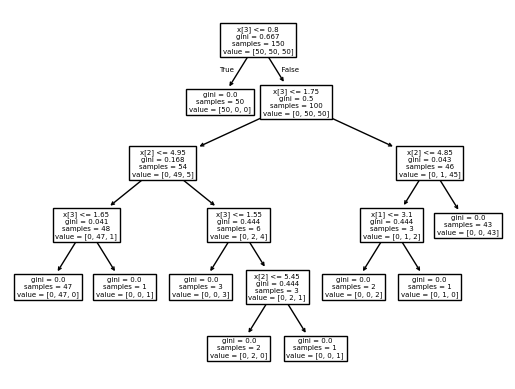

In [78]:
# Пример с iris 
from sklearn.datasets import load_iris
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=0)
iris = load_iris()

display(pd.DataFrame(iris.data[:5], columns=iris.feature_names))

clf = clf.fit(iris.data, iris.target)
tree.plot_tree(clf)

In [79]:
def plot_tree_scores(depths):
    train_scores = []
    test_scores = []
    
    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, color='blue', label='train score')
    plt.plot(depths, test_scores, color='green', label='test score')
    plt.legend()

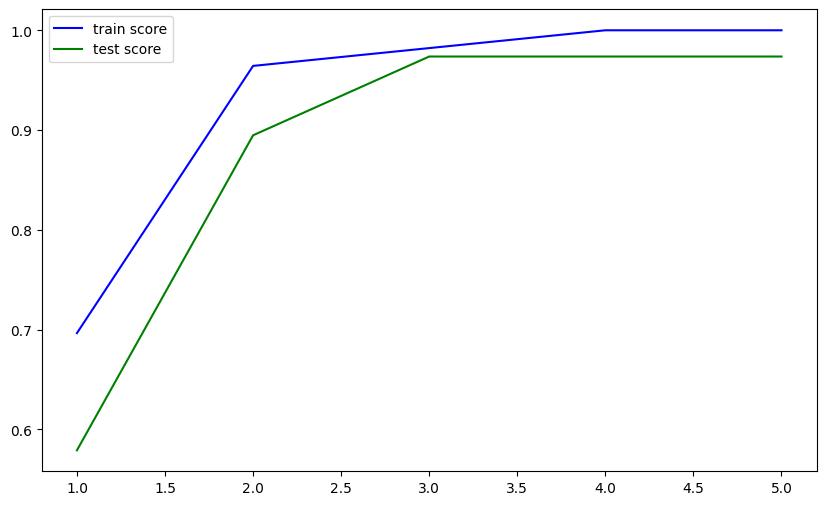

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
plot_tree_scores(range(1, 6))

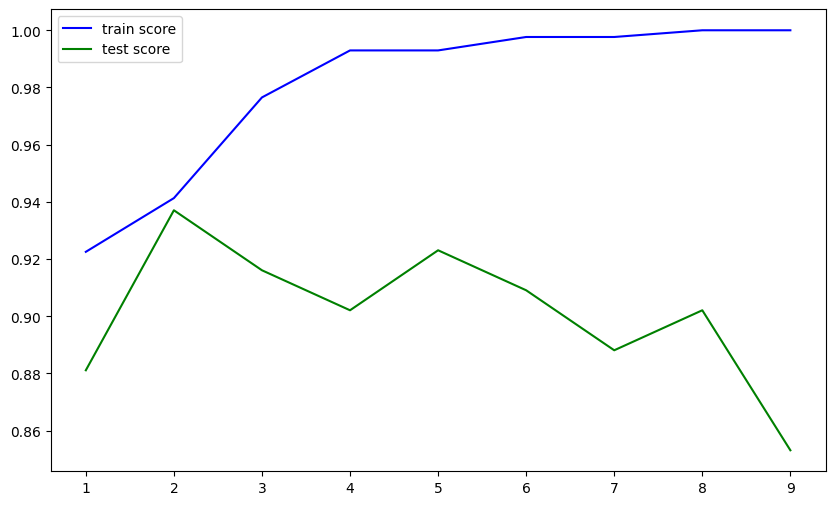

In [81]:
# За breast cancer 
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)
plot_tree_scores(range(1, 10))

Сега ще разгледаме по-подробно какво се случва с помощта на едни синтетични данни за класификация.

In [82]:
from sklearn.datasets import make_classification
x, y = make_classification(n_samples=100,
                           n_features=2,
                           n_redundant=0, 
                           n_clusters_per_class=2, 
                           random_state=123)

In [83]:
print(x[:4])
print(y[:4])

[[-0.01032243 -0.80566819]
 [-1.10293659  2.21661117]
 [-1.90795358 -0.20839902]
 [ 0.53115524  2.2762704 ]]
[1 0 0 1]


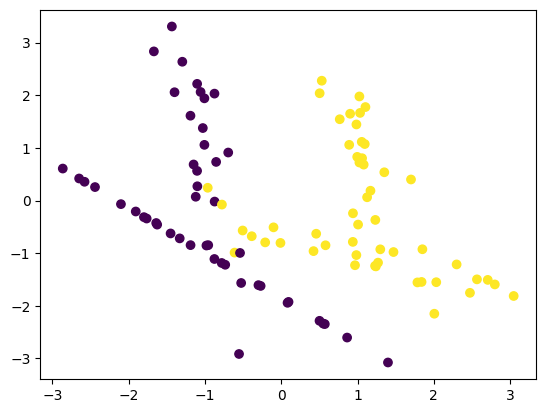

In [84]:
plt.scatter(x[:,0], x[:,1], c=y);

In [85]:
# Plotting decision regions adapted from 
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

def plot_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, ax = plt.subplots(figsize=(10, 8))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    
    plt.show()

In [86]:
clf = DecisionTreeClassifier().fit(x,y)
print(clf.score(x, y))

#Cross validation
scores = cross_val_score(clf, x, y, cv=5)
print(scores)
print(scores.mean())

1.0
[0.95 0.95 0.9  0.85 1.  ]
0.93


### Как се учи алгоритъмът?

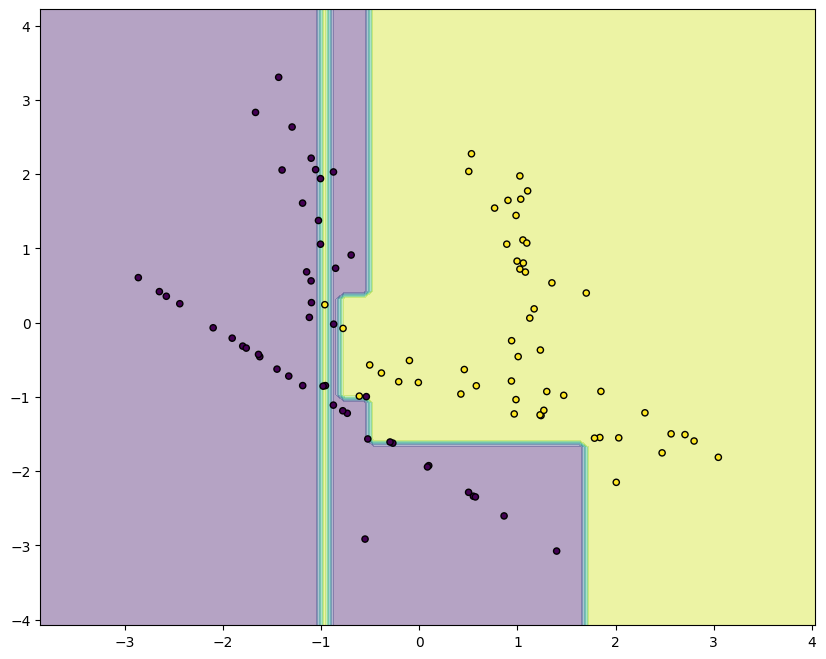

In [87]:
clf = DecisionTreeClassifier().fit(x, y)
plot_boundary(clf, x, y)

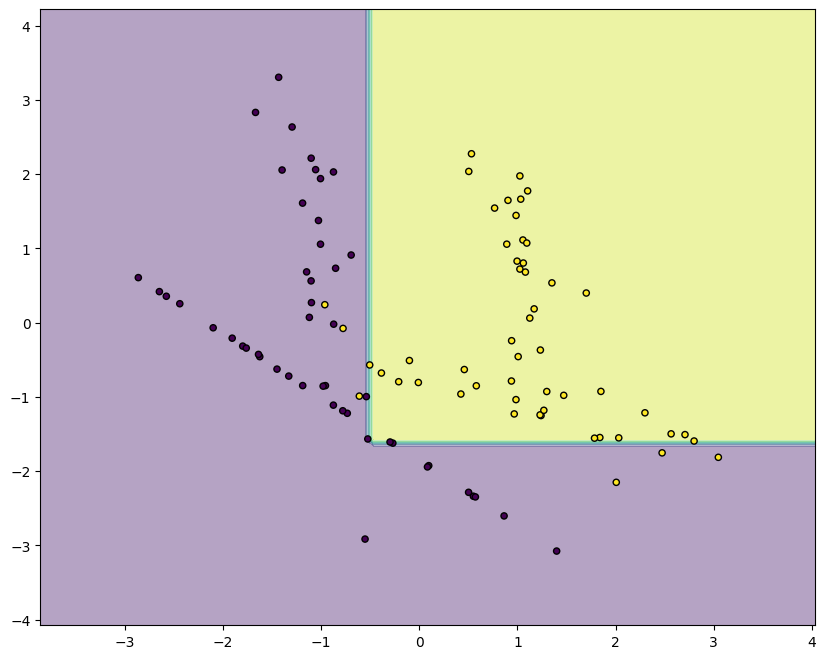

In [88]:
clf = DecisionTreeClassifier(min_samples_split=50).fit(x, y)
plot_boundary(clf, x, y)

[Text(0.4, 0.8333333333333334, 'x[0] <= -0.516\ngini = 0.499\nsamples = 100\nvalue = [48, 52]'),
 Text(0.2, 0.5, 'gini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= -1.601\ngini = 0.262\nsamples = 58\nvalue = [9, 49]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.375\nsamples = 12\nvalue = [9, 3]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 46\nvalue = [0, 46]')]

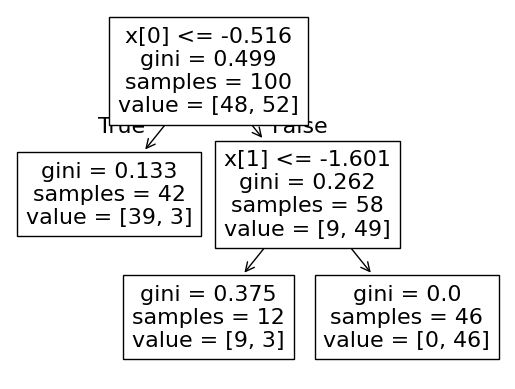

In [89]:
from sklearn import tree
tree.plot_tree(clf)

## В `sklearn` е имплементиран CART алгоритъм. 

### Classification and Regression Trees

L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984

http://scikit-learn.org/stable/modules/tree.html#tree

### Моделът CART е двоично дърво. 
#### Процесът

1. Старт (Корен): Алгоритъмът поглежда всичките ви данни в коренния възел.

2. Намиране на най-добрия "въпрос": Той итерира през:
- Всяка характеристика (feature), която имате (напр. "дължина на листо", "ширина на листо"...).
- Всяка възможна стойност за разделяне (напр. "дължина <= 5.1?", "дължина <= 5.2?", "ширина <= 3.1?"...).

3. Избор на "победител": Той избира единствения въпрос (една характеристика и една стойност), който води до най-голяма "чистота" в двете нови групи. Това е мястото, където влизат Gini или Ентропията. Въпросът, който води до най-голямо намаляване на "примесите" (Information Gain), печели.

4. Разделяне: Данните се разделят на две нови групи (дъщерни възли) въз основа на отговора на въпроса.

5. Рекурсия: Алгоритъмът повтаря стъпки 1-4 за всеки от новите възли.
--- 
Всеки елемент от дървото може да има нула, едно или две деца.    

Алгоритъмът работи рекурсивно.      

Критерии за спиране могат да бъдат:    
* Достигната е абсолютна чистота на елементите в дървото. (останали са само един клас данни в последните деца)
* Достигната е максимална дълбочина на дървото. (`max_depth`)
* Достигнат е минимален брой примери за разделяне. (`min_samples_split`)

### Алгоритъмът е алчен (greedy):
* Проверява всяка възможна колона (feature) за всички възможни раздвоявания и избира най-доброто.
* Сложност при трениране: $O(n_{features}n_{samples}\log(n_{samples}))$

### Оценяваща функция:
* Оценяващата функция работи, чрез информационна печалба (Information gain):
$$ InformationGain = impurity(parent) - {WeightedAverageBySamplesCount}\sum{impurity(children)}$$

### Измерване на "примеси" (Impurity measures)

#### Класификация:
1. Ентропия (Entropy)
2. Gini
3. Неправилна класификация (Misclassification)

#### Регресия:
1. Средно аритметично от разликата на квадратите (Mean Squared Error)
2. Средно аритметично от абсолютната стойност на разликата (Mean Absolute Error)

### При предвиждане на нов запис, алгоритъмът се спуска по построеното дърво докато стигне възел без наследници.
* При регресия - предвижда средната стойнoст от записите останали в последния елемент.
* При класификация избира класа представен от мнозинството от записи останали в последния елемент.
* Сложност при предвиждане: $O(\log(n_{samples}))$

## Измерване на примесите (impurity)

### Ентропия
- От теория на информацията: мярка за нееднородност на дадено множество от примери.    
За множество S с примери от два класа - положителни и отрицателни:     
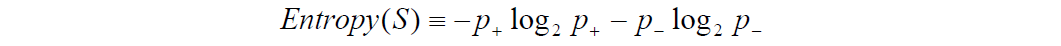   
където:
- $p_+$ e пропорцията на положителните примери в S,
- $p_-$ е пропорцията на отрицателните примери в S.

В общия случай:

 $$Entropy(S) = \sum_i{ - p_i  log_2(  p_i )}$$
 
 $$p_i= \frac{size of class_i}{size of set}$$

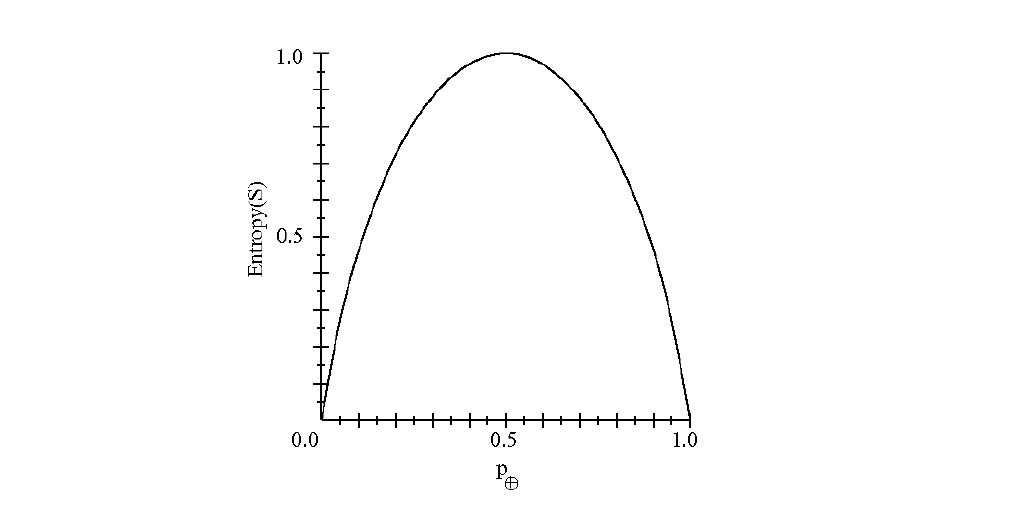

### Пример:

['Лъчо', 'Лъчо', 'Стефан', Стефан']

Лъчо - 2, Стефан - 2

Пропорции:

Лъчо: $\frac{2}{4}$, Стефан: $\frac{2}{4}$

Стойност за Лъчо: 
$$-\frac{2}{4} * log_2(\frac{2}{4})$$
$$-0.5 * -1$$
$$0.5$$

Стефан има същата стойност $0.5$.

Ентропията на множеството е $$entropy=0.5+0.5 = 1.0$$


### Пример 2:

['Круши', 'Круши', 'Круши']

Круши - 3

Пропорции:

Круши $\frac{3}{3} = 1$

$$-1 * log_2(1)$$
$$-1 * 0$$
$$entropy=0$$

In [90]:
def entropy(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    entropy = sum([-subset_count * np.log2(subset_count +0.000000000001) 
                   for subset_count in subset_counts_normalized])
    
    entropy = np.round(entropy, 4)
    print('Entropy for', subset_counts, " is:", entropy)
    return entropy

In [91]:
samples = [[2,0], [1,0], [9,1], [4,4]]

for sample in samples:
    entropy(sample)

Entropy for [2 0]  is: -0.0
Entropy for [1 0]  is: -0.0
Entropy for [9 1]  is: 0.469
Entropy for [4 4]  is: 1.0


In [92]:
samples = [[2,0,1], [6,0,0], [9,1,0], [5,5,0], [5,5,5]]

for sample in samples:
    entropy(sample)

Entropy for [2 0 1]  is: 0.9183
Entropy for [6 0 0]  is: -0.0
Entropy for [9 1 0]  is: 0.469
Entropy for [5 5 0]  is: 1.0
Entropy for [5 5 5]  is: 1.585


## Gini

$Gini(X) = \sum_i p_{i} (1 - p_{i})$,     

където $p_{i}$ е вероятността един елемент да е от клас *i*.

### Пример:

['Лъчо', 'Лъчо', 'Стефан', Стефан']

Лъчо - 2, Стефан - 2

Пропорции:

Лъчо: $\frac{2}{4}$, Стефан: $\frac{2}{4}$

Стойност за Лъчо: 
$$\frac{2}{4} * (1 - \frac{2}{4})$$
$$0.5 * 0.5$$
$$0.25$$

Стефан има същата стойност $0.25$.

$$gini=0.25+0.25 = 0.5$$


### Пример 2:

['Круши', 'Круши', 'Круши']

Круши - 3

Пропорции:

Круши $\frac{3}{3} = 1$

$$1 * (1 - 1)$$
$$1 * 0$$
$$gini=0$$

In [93]:
def gini_impurity(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    impurity = sum([subset_count * (1 - subset_count) 
                    for subset_count in subset_counts_normalized])
    
    print('Gini impurity for', subset_counts, " is:", impurity)
    return impurity

In [94]:
samples = [[2,0], [1,0], [9,1], [4,4]]

for sample in samples:
    gini_impurity(sample)

Gini impurity for [2 0]  is: 0.0
Gini impurity for [1 0]  is: 0.0
Gini impurity for [9 1]  is: 0.18
Gini impurity for [4 4]  is: 0.5


In [95]:
samples = [[2,0,1], [6,0,0], [9,1,0], [5,5,0], [5,5,5]]

for sample in samples:
    gini_impurity(sample)

Gini impurity for [2 0 1]  is: 0.4444444444444445
Gini impurity for [6 0 0]  is: 0.0
Gini impurity for [9 1 0]  is: 0.18
Gini impurity for [5 5 0]  is: 0.5
Gini impurity for [5 5 5]  is: 0.6666666666666667


## Неправилна класификация (Misclassification)

$Misclassification(X) = 1 - \max(p_{i})$


In [96]:
def missclassification_impurity(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    impurity = 1 - max(subset_counts_normalized)
    
    print('Misclassification impurity for', subset_counts, " is:", impurity)
    return impurity

In [97]:
samples = [[2,0], [1,0], [9,1], [4,4]]

for sample in samples:
    missclassification_impurity(sample)

Misclassification impurity for [2 0]  is: 0.0
Misclassification impurity for [1 0]  is: 0.0
Misclassification impurity for [9 1]  is: 0.09999999999999998
Misclassification impurity for [4 4]  is: 0.5


In [98]:
samples = [[2,0,1], [6,0,0], [9,1,0], [5,5,0], [5,5,5]]

for sample in samples:
    missclassification_impurity(sample)

Misclassification impurity for [2 0 1]  is: 0.33333333333333337
Misclassification impurity for [6 0 0]  is: 0.0
Misclassification impurity for [9 1 0]  is: 0.09999999999999998
Misclassification impurity for [5 5 0]  is: 0.5
Misclassification impurity for [5 5 5]  is: 0.6666666666666667


## Информационна печалба 

$ InformationGain = impurity(parent) - {WeightedAverageBySamplesCount}\sum{impurity(children)}$

- Очакваното намаляване на примесите, предизвикано от разделяне на примери в съответствие със стойностите на избрания атрибут.

Информационна печалба - при ентропия:      
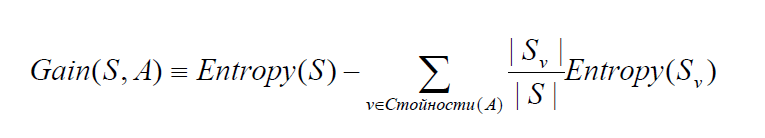 където:     
- *Стойности(A)* е множеството от възможни стойности на атрибута *А*
- $S_v$ - подмножеството на *S*, в което всички примери имат стойността на атрибута *А*, равна на *v*

In [99]:
def information_gain(subsets, parent_entropy=1, f=entropy):
    total_count = sum([sum(i) for i in subsets])
    print("total count:", total_count)
    subsets_impurity = sum((sum(subset) / total_count * f(subset) for subset in subsets))
    IG = parent_entropy - subsets_impurity
    print("Information gain:", IG)
    return IG

In [100]:
#paternt - [2, 2]
subsets = [[2,1], [1]]
for f in [entropy, gini_impurity, missclassification_impurity]:
    information_gain(subsets, parent_entropy=1, f=f); 
    print();

total count: 4
Entropy for [2 1]  is: 0.9183
Entropy for [1]  is: -0.0
Information gain: 0.31127499999999997

total count: 4
Gini impurity for [2 1]  is: 0.4444444444444445
Gini impurity for [1]  is: 0.0
Information gain: 0.6666666666666666

total count: 4
Misclassification impurity for [2 1]  is: 0.33333333333333337
Misclassification impurity for [1]  is: 0.0
Information gain: 0.75



In [101]:
subsets = [[2], [2]]
for f in [entropy, gini_impurity, missclassification_impurity]:
    information_gain(subsets, parent_entropy=1, f=f); 
    print();

total count: 4
Entropy for [2]  is: -0.0
Entropy for [2]  is: -0.0
Information gain: 1.0

total count: 4
Gini impurity for [2]  is: 0.0
Gini impurity for [2]  is: 0.0
Information gain: 1.0

total count: 4
Misclassification impurity for [2]  is: 0.0
Misclassification impurity for [2]  is: 0.0
Information gain: 1.0



[Text(0.4, 0.8333333333333334, 'x[0] <= -0.516\ngini = 0.499\nsamples = 100\nvalue = [48, 52]'),
 Text(0.2, 0.5, 'gini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= -1.601\ngini = 0.262\nsamples = 58\nvalue = [9, 49]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.375\nsamples = 12\nvalue = [9, 3]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 46\nvalue = [0, 46]')]

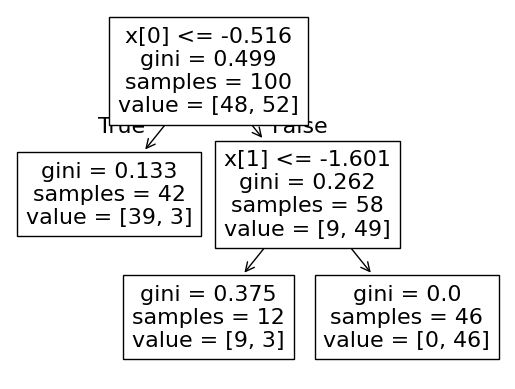

In [102]:
tree.plot_tree(clf)

In [103]:
gini_impurity([48,52])
gini_impurity([9, 49])
gini_impurity([39, 3])
gini_impurity([0, 46]);

Gini impurity for [48 52]  is: 0.4992
Gini impurity for [ 9 49]  is: 0.2621878715814506
Gini impurity for [39  3]  is: 0.13265306122448978
Gini impurity for [ 0 46]  is: 0.0


### Плюсове: 
* Дървото е лесно за интерпретация.
* Лесно се справя с ирелевантни атрибути (*gain =0*).
* Може да се справи с липсващи данни. (Не и за текущата имплементация в sklearn).
* Компактно представяне на модела.
* Бърз при предсказване: *O(дълбочината на дървото)*.
* Може да прави класификация с повече класове без допълнителни трикове.
* Лесен за използване и дава добри резултати с малко експерименти.

### Минуси:
* Разделя атрибутите само по осите. 
* Алчен (greedy) - може да не открие най-доброто дърво.
* Експоненциално нарастване на възможните дървета.
* Овърфитва силно.

## Въпроси по DT?

## Random Forest

- Пример за обучение чрез ансамбли (ensemble learning)
- Обучава множество от дървета (гора) на случайни подмножества от данните и осреднява резултатите

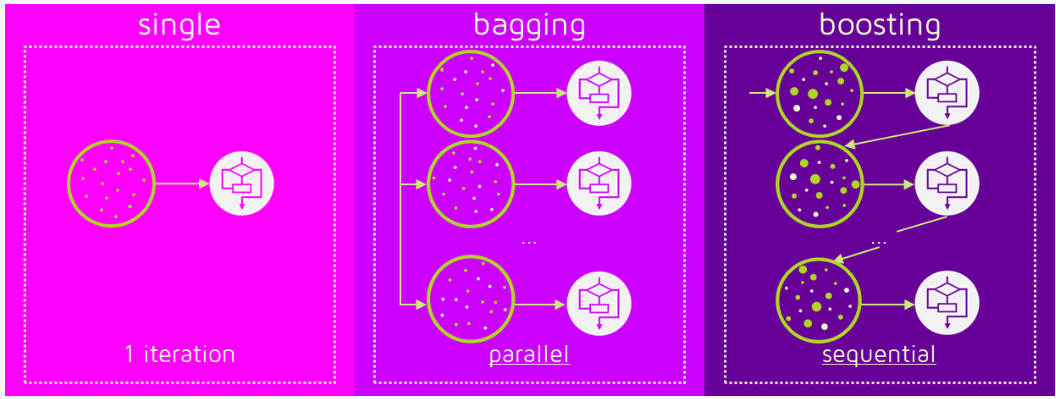

In [104]:
from sklearn.ensemble import RandomForestClassifier

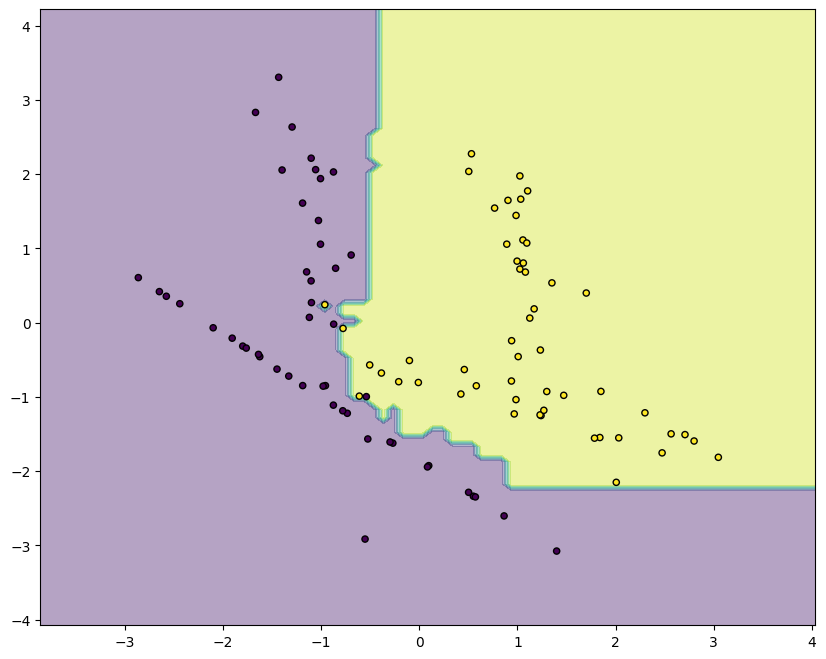

In [105]:
clf = RandomForestClassifier(random_state=23).fit(x,y) # без настройка на параметрите
plot_boundary(clf, x, y)

## Параметри за RF:

* `n_estimators`: брой дървета - 10, 100, 1000 
* `criterion`: за всички дървета  - gini, entropy
* `max_features`: Колко фичъра да се пробват при търсене на най-добро разделяне. По подразбиране - `sqrt(n_features)` - различни при всяко ново търсене.
* `max_depth`: Максимална дълбочина на дърветата
* `min_samples_split`: Минимален брой семпли за да може да се раздели възела
* `bootstrap` - Втори параметър за случайност - random sampling with replacement. Тегли същия брой семпли като оригиналния сет.
* `n_jobs` - Тренира по няколко дървета едновременно, но използва повече памет.
* `random_state` - възпроизведими експерименти

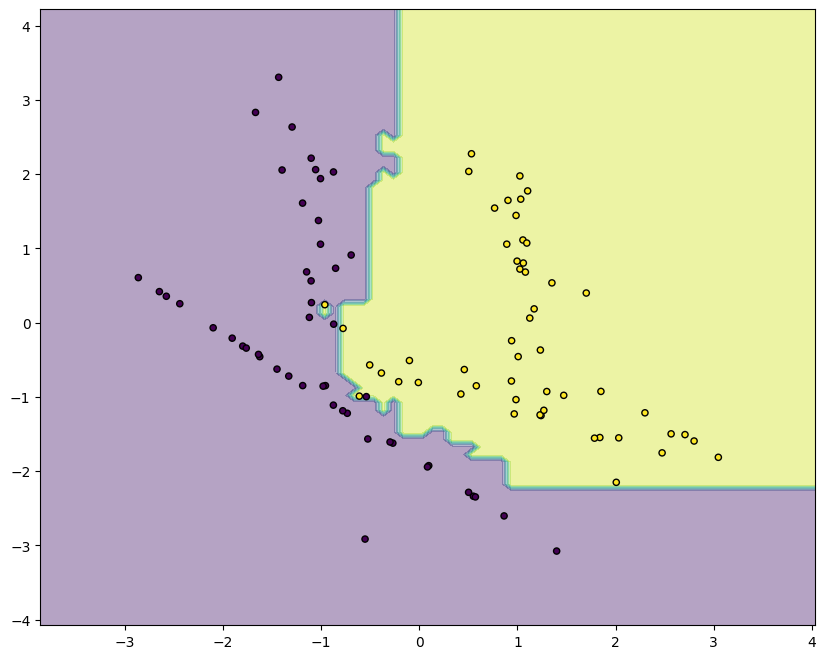

In [106]:
clf = RandomForestClassifier(random_state=100).fit(x,y)
plot_boundary(clf, x, y)

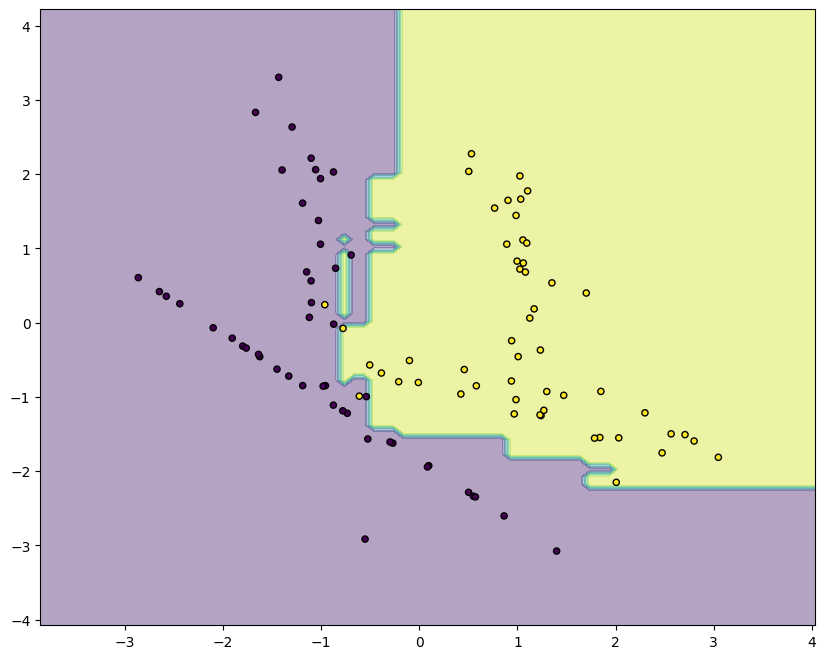

In [107]:
# Тъй като е случайно, можем да получим и различна граница 
clf = RandomForestClassifier(n_estimators=10).fit(x,y)
plot_boundary(clf, x, y)

### Значимост на характеристиките (feature importance) в RF - Сходно на теглата на параметрите при линейни модели.
![](http://scikit-learn.org/stable/_images/sphx_glr_plot_forest_importances_001.png)
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

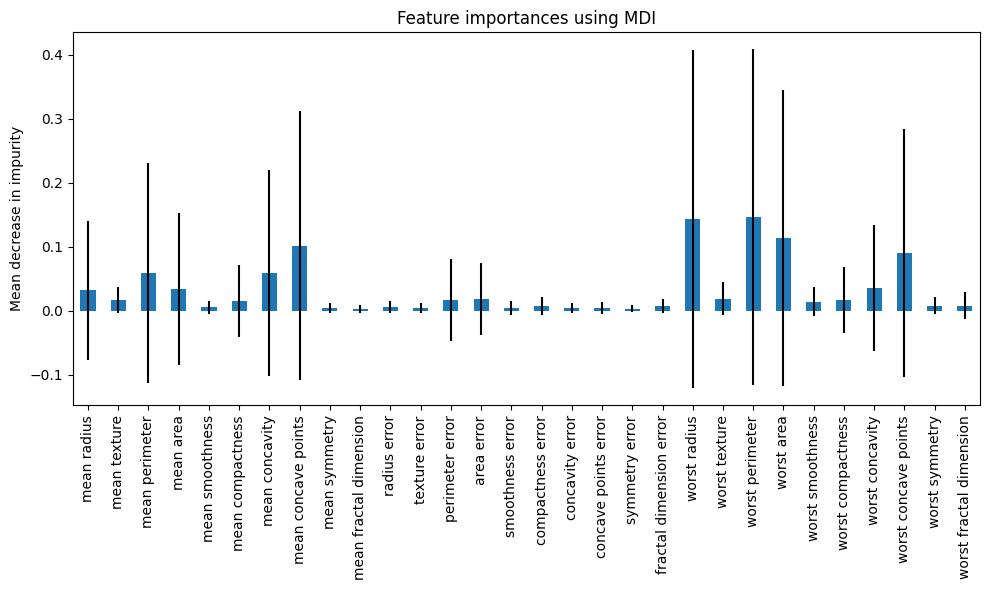

In [108]:
#За breast cancer
import pandas as pd
data = load_breast_cancer()
forest = RandomForestClassifier().fit(data.data, data.target)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=data.feature_names)

fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## AdaBoost

Boosting algorithm

1. Тренираме слаб модел върху данните 

2. Повтаряме *n* пъти:

        Тренираме нов слаб модел като даваме повече тежест на данните, които
        предишния класифицира грешно

3. Резултат всички слаби модели

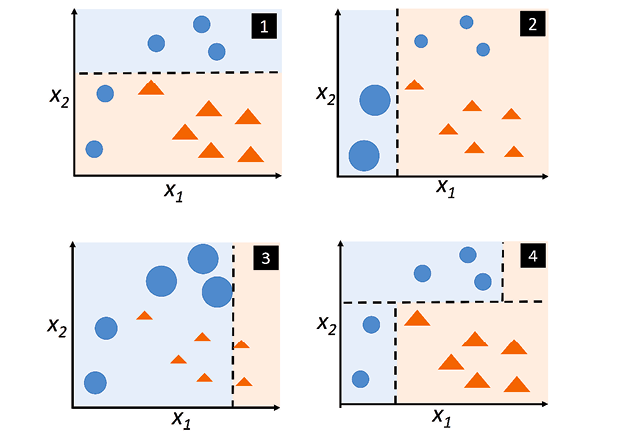

## XGBoost

1. Тренираме слаб модел върху данните

2. Повтаряме докато не стигнем критерий за терминиране:

        Тренираме нов слаб модел върху грешката на предишните

3. Резултат всички слаби модели

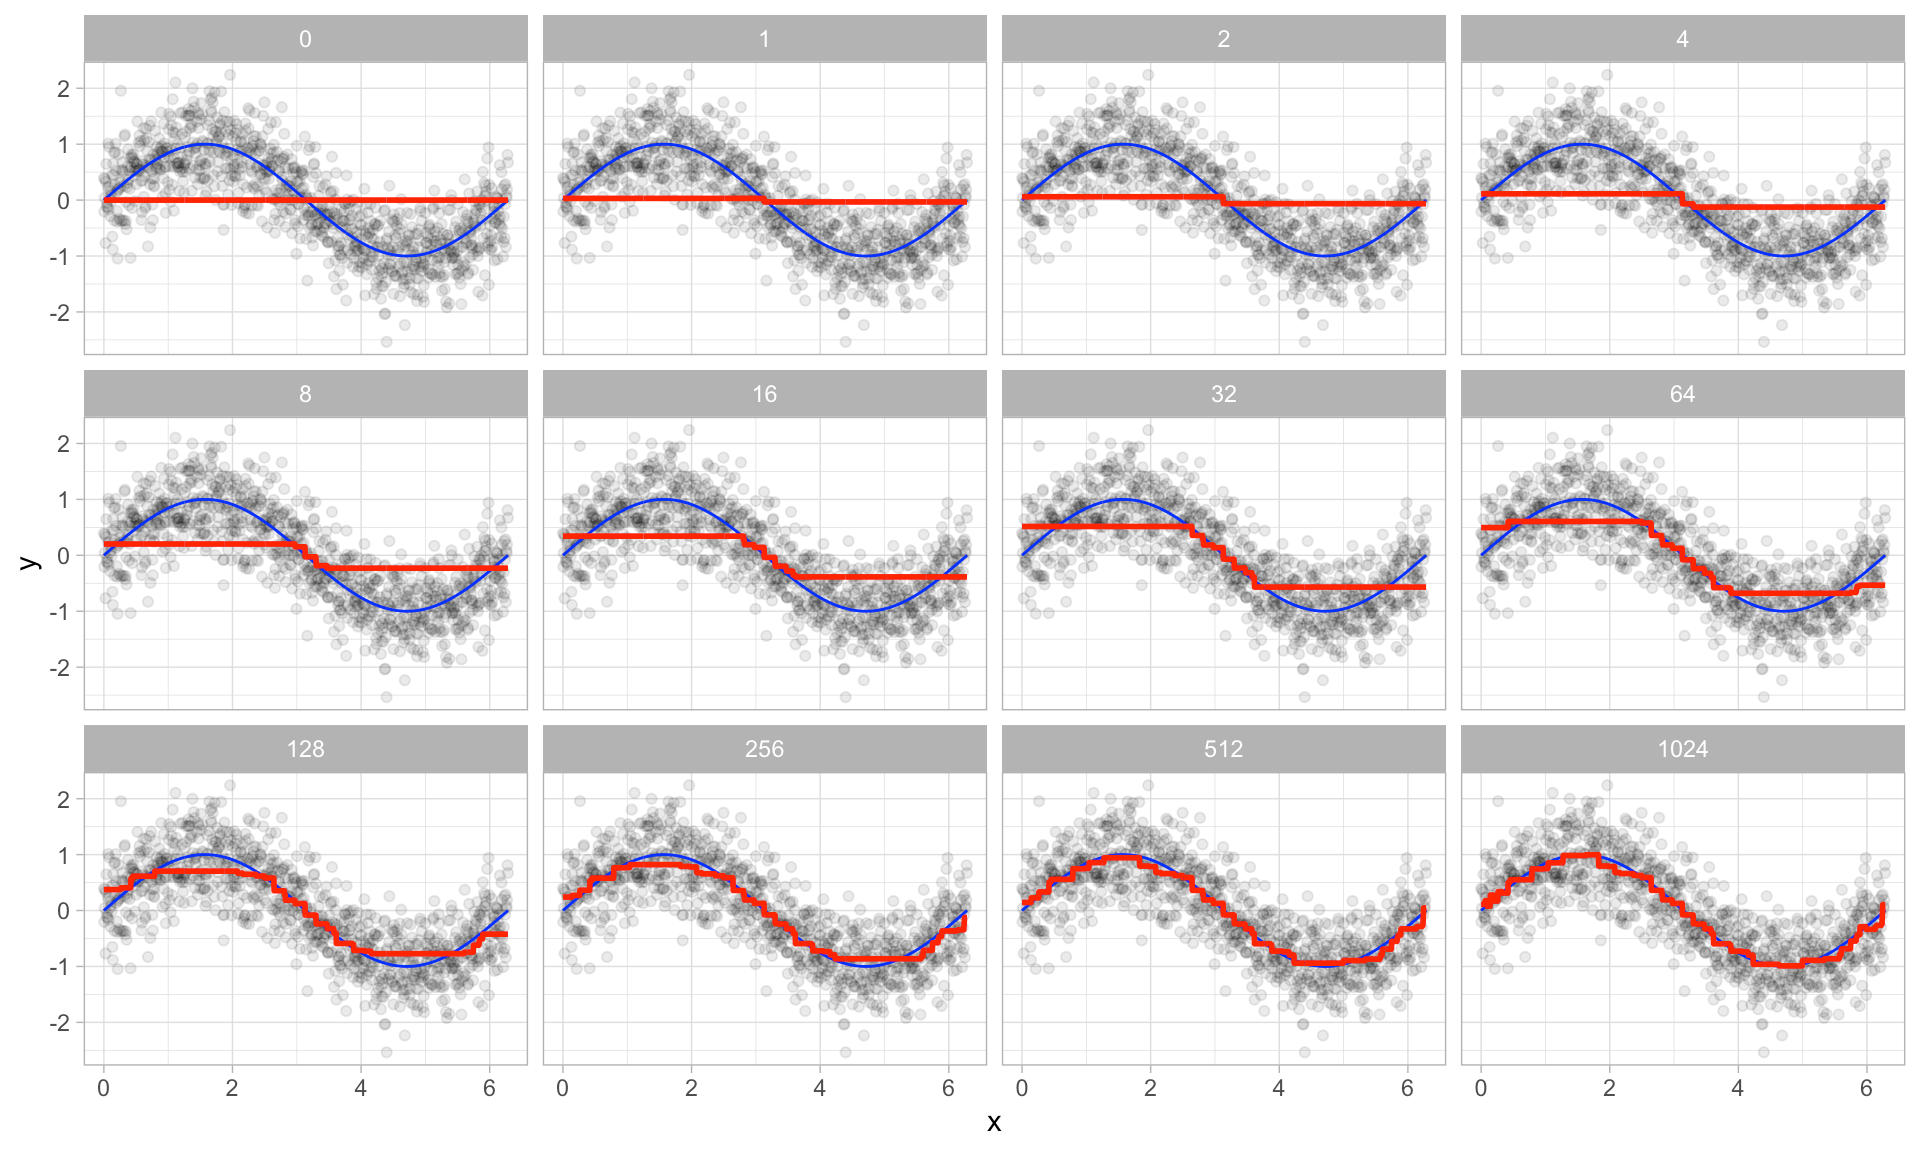

### Задача: 
    
Изпробвайте влиянието върху генерализацията на DT и RF при промяна на параметрите `min_samples_split` и `n_estimators` (за RF) за избран от вас набор от данни.

### Прочетете документацията:
* http://scikit-learn.org/stable/modules/tree.html
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [109]:
# Решение 
def plot_tree_scores(n_estimators):
    train_scores = []
    test_scores = []
    
    for n in n_estimators:
        clf = RandomForestClassifier(n_estimators=n).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators, train_scores, color='blue', label='train score')
    plt.plot(n_estimators, test_scores, color='green', label='test score')
    plt.legend()

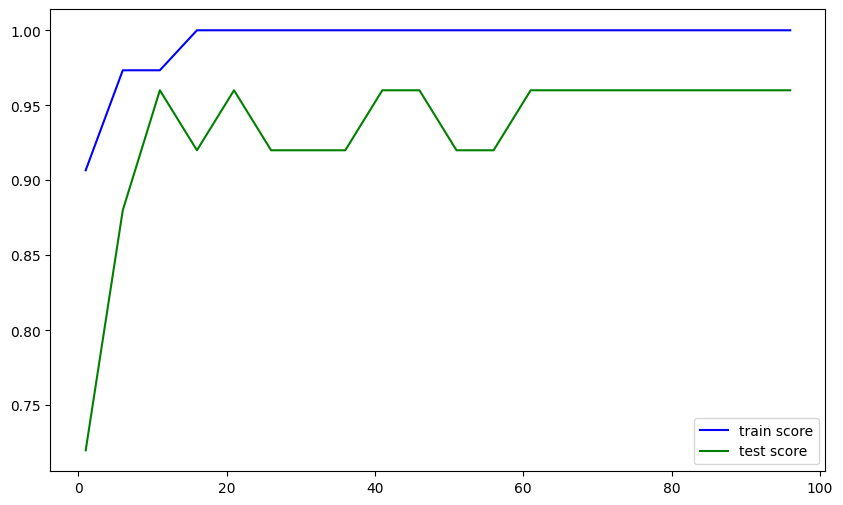

In [112]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
plot_tree_scores(range(1, 100, 5))